In [1]:
#!pip install matplotlib xarray numpy scipy netCDF4

import matplotlib.pyplot as pl
import xarray as xr
import numpy as np

from scipy.interpolate import interp1d

In [2]:
"""
Help functions
"""
def xr_read_all(f, groups, decode_times=True):
    """
    Read all NetCDF groups into a single Xarray Dataset.
    """
    dss = [xr.open_dataset(f, decode_times=decode_times)]
    for group in groups:
        dss.append(xr.open_dataset(f, group=group, decode_times=decode_times))
    return xr.merge(dss)

In [3]:
"""
Read LES results.
"""
path = '/home/scratch1/bart/microhh/papers/dust_mahrooz_dirk/v1/high-res/'

# Read column statistics of virtual BSNE.
ds1 = xr.open_dataset(f'{path}/20220511/valthermond.column.00130.00297.nc')
ds3 = xr.open_dataset(f'{path}/20220623/valthermond.column.00130.00297.nc')

# Time averages.
ds1m = ds1.mean(dim='time')
ds3m = ds3.mean(dim='time')

# Read default statistics for basestate density.
ds1d = xr_read_all(f'{path}/20220511/valthermond.default.0025200.nc', ['thermo'])
ds3d = xr_read_all(f'{path}/20220623/valthermond.default.0000000.nc', ['thermo'])


In [9]:
"""
Read data Dirk.
"""

z_obs = np.array([25, 50, 75, 100, 150])

# Data 3 May 2022 - 17 May 2022.
c_obs_1 = np.array([
    [39.8,  33.1, 19.7, 15.8, 12.5],    # 5 um
    [59.6,  53.9, 32.8, 27.7, 21.1],    # 10 um
    [109.3, 82.6, 62.9, 49.0, 37.7],    # 42 um
    [39.5,  20.7, 14.9, 11.0, 8.7]])    # 72 um

# Data 14 June 2022 - 28 June 2022.
c_obs_2 = np.array([
    [4.4, 2.1, 1.5, 1.5, 1.3],          # 5 um
    [7.5, 3.6, 2.6, 2.5, 2.2],          # 10 um
    [8.5, 3.8, 2.8, 2.4, 2.2],          # 42 um
    [2.4, 1.0, 0.6, 0.6, 0.4]])         # 72 um

The dust sizes in the observations and LES do not match.

For a 1:1 comparison, we interpolate the observed concentrations to the dust sizes in LES.

The smalles size in LES is 1 um, which is outside the range of the observations, and therefore requires a (dangerous?) extrapolation. Perhaps best not to use that size.

Would it be easier to use the sizes from the observations directly in LES?

In [5]:
"""
Interpolate observations to concentrations LES.
Perhaps it is easier to set the LES sizes to the observed ones...?
NOTE: this currently extrapolates for the smallest size in LES, which sounds dangerous...
"""

c_in = np.array([5, 10, 42, 72])
c_out = np.array([1, 6, 15, 39, 70.5])
z_out = z_obs

c_int_1 = np.zeros((c_out.size, z_out.size))
c_int_2 = np.zeros((c_out.size, z_out.size))

for k in range(z_out.size):
    f = interp1d(c_in, c_obs_1[:,k], kind='linear', fill_value='extrapolate')
    c_int_1[:,k] = f(c_out)

    f = interp1d(c_in, c_obs_2[:,k], kind='linear', fill_value='extrapolate')
    c_int_2[:,k] = f(c_out)

Text(0, 0.5, 'z (cm)')

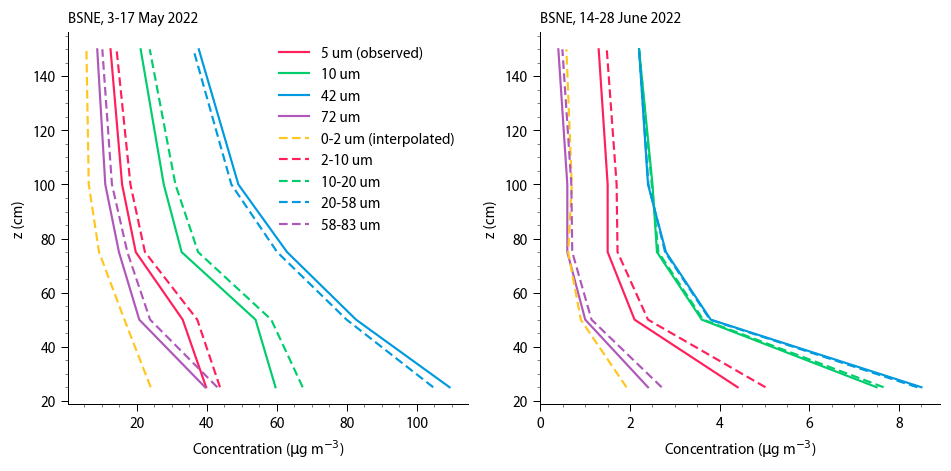

In [6]:
"""
Check!
"""

pl.figure(figsize=(8,4), layout='tight')
pl.subplot(121)
pl.title('BSNE, 3-17 May 2022', loc='left')
pl.plot(c_obs_1[0], z_obs, color='C0', label='5 um (observed)')
pl.plot(c_obs_1[1], z_obs, color='C1', label='10 um')
pl.plot(c_obs_1[2], z_obs, color='C2', label='42 um')
pl.plot(c_obs_1[3], z_obs, color='C3', label='72 um')

pl.plot(c_int_1[0], z_obs, color='C4', dashes=[4,2], label='0-2 um (interpolated)')
pl.plot(c_int_1[1], z_obs, color='C0', dashes=[4,2], label='2-10 um')
pl.plot(c_int_1[2], z_obs, color='C1', dashes=[4,2], label='10-20 um')
pl.plot(c_int_1[3], z_obs, color='C2', dashes=[4,2], label='20-58 um')
pl.plot(c_int_1[4], z_obs, color='C3', dashes=[4,2], label='58-83 um')

pl.legend()
pl.xlabel(r'Concentration ($\mathrm{\mu}$g m$^{-3}$)')
pl.ylabel('z (cm)')

pl.subplot(122)
pl.title('BSNE, 14-28 June 2022', loc='left')
pl.plot(c_obs_2[0], z_obs, color='C0')
pl.plot(c_obs_2[1], z_obs, color='C1')
pl.plot(c_obs_2[2], z_obs, color='C2')
pl.plot(c_obs_2[3], z_obs, color='C3')

pl.plot(c_int_2[0], z_obs, color='C4', dashes=[4,2])
pl.plot(c_int_2[1], z_obs, color='C0', dashes=[4,2])
pl.plot(c_int_2[2], z_obs, color='C1', dashes=[4,2])
pl.plot(c_int_2[3], z_obs, color='C2', dashes=[4,2])
pl.plot(c_int_2[4], z_obs, color='C3', dashes=[4,2])

pl.xlabel(r'Concentration ($\mathrm{\mu}$g m$^{-3}$)')
pl.ylabel('z (cm)')

In [7]:
"""
Least squares fit of LES to observed dust concentration.
"""

# Interpolate LES to the observation heights.
ds1m_z = ds1m.interp(z=z_obs/100, zh=z_obs/100)
ds3m_z = ds3m.interp(z=z_obs/100, zh=z_obs/100)

rho_d1_z = ds1d.rhoref.interp(z=z_obs/100)
rho_d3_z = ds3d.rhoref.interp(z=z_obs/100)

# Least squares fit for each concentration, to get a scaling factor per size category.
N = c_int_1.shape[0]
f1 = np.zeros(N)
f3 = np.zeros(N)

def calc_scaling(model, obs):
    return np.dot(obs, model) / np.dot(model, model)

# Units model = kg kg-1. Units BSNE = ug m-3.
# Conversion kg to ug is included in the scale factor.
f1[0] = calc_scaling(ds1m_z['0-2um'  ].values * rho_d1_z.values, c_int_1[0])
f1[1] = calc_scaling(ds1m_z['2-10um' ].values * rho_d1_z.values, c_int_1[1])
f1[2] = calc_scaling(ds1m_z['10-20um'].values * rho_d1_z.values, c_int_1[2])
f1[3] = calc_scaling(ds1m_z['20-58um'].values * rho_d1_z.values, c_int_1[3])
f1[4] = calc_scaling(ds1m_z['58-83um'].values * rho_d1_z.values, c_int_1[4])

f3[0] = calc_scaling(ds3m_z['0-2um'  ].values * rho_d3_z.values, c_int_2[0])
f3[1] = calc_scaling(ds3m_z['2-10um' ].values * rho_d3_z.values, c_int_2[1])
f3[2] = calc_scaling(ds3m_z['10-20um'].values * rho_d3_z.values, c_int_2[2])
f3[3] = calc_scaling(ds3m_z['20-58um'].values * rho_d3_z.values, c_int_2[3])
f3[4] = calc_scaling(ds3m_z['58-83um'].values * rho_d3_z.values, c_int_2[4])


(0.0, 150.0)

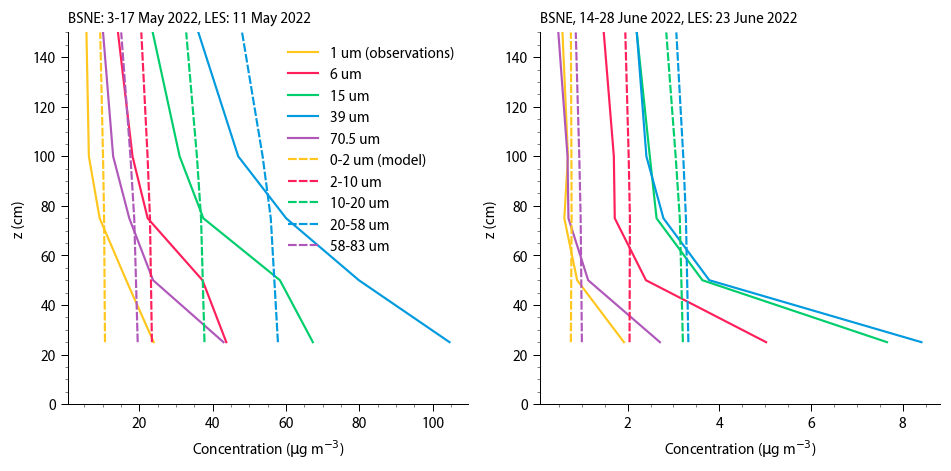

In [8]:
"""
Plot scaled profiles LES.
"""

pl.figure(figsize=(8,4), layout='tight')
pl.subplot(121)
pl.title('BSNE: 3-17 May 2022, LES: 11 May 2022', loc='left')

pl.plot(c_int_1[0], z_obs, color='C4', label='1 um (observations)')
pl.plot(c_int_1[1], z_obs, color='C0', label='6 um')
pl.plot(c_int_1[2], z_obs, color='C1', label='15 um')
pl.plot(c_int_1[3], z_obs, color='C2', label='39 um')
pl.plot(c_int_1[4], z_obs, color='C3', label='70.5 um')

pl.plot(f1[0]*ds1m_z['0-2um'],   ds1m_z.z*100, color='C4', dashes=[4,1], label='0-2 um (model)')
pl.plot(f1[1]*ds1m_z['2-10um'],  ds1m_z.z*100, color='C0', dashes=[4,1], label='2-10 um')
pl.plot(f1[2]*ds1m_z['10-20um'], ds1m_z.z*100, color='C1', dashes=[4,1], label='10-20 um')
pl.plot(f1[3]*ds1m_z['20-58um'], ds1m_z.z*100, color='C2', dashes=[4,1], label='20-58 um')
pl.plot(f1[4]*ds1m_z['58-83um'], ds1m_z.z*100, color='C3', dashes=[4,1], label='58-83 um')

pl.legend()
pl.xlabel(r'Concentration ($\mathrm{\mu}$g m$^{-3}$)')
pl.ylabel('z (cm)')
pl.ylim(0,150)

pl.subplot(122)
pl.title('BSNE, 14-28 June 2022, LES: 23 June 2022', loc='left')

pl.plot(c_int_2[0], z_obs, color='C4')
pl.plot(c_int_2[1], z_obs, color='C0')
pl.plot(c_int_2[2], z_obs, color='C1')
pl.plot(c_int_2[3], z_obs, color='C2')
pl.plot(c_int_2[4], z_obs, color='C3')

pl.plot(f3[0]*ds3m_z['0-2um'],   ds3m_z.z*100, color='C4', dashes=[4,1])
pl.plot(f3[1]*ds3m_z['2-10um'],  ds3m_z.z*100, color='C0', dashes=[4,1])
pl.plot(f3[2]*ds3m_z['10-20um'], ds3m_z.z*100, color='C1', dashes=[4,1])
pl.plot(f3[3]*ds3m_z['20-58um'], ds3m_z.z*100, color='C2', dashes=[4,1])
pl.plot(f3[4]*ds3m_z['58-83um'], ds3m_z.z*100, color='C3', dashes=[4,1])

pl.xlabel(r'Concentration ($\mathrm{\mu}$g m$^{-3}$)')
pl.ylabel('z (cm)')
pl.ylim(0,150)

It is clear that LES does not capture the profile shape from the observations. There are several possible reasons;
1. Resolution LES is still insufficient.
2. We only simulate one day, and observations are 14 days. Perhaps the single LES day is more turbulent/convective, and therefore better well-mixed.
3. ?

Can we live with the idea that the scaling factor is only meant to match the mean LES concentration to the mean BSNE concentration?